KNN - DTW

=============================================================================================================

In [1]:
from sklearn.metrics import classification_report
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

import os
import numpy as np
import pandas as pd
import seaborn as sns
import random

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sktime.datasets import load_airline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.paa import PAA
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.pipeline import make_pipeline

from scipy.spatial.distance import euclidean

from datetime import datetime
from collections import defaultdict

from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import sys

from sktime.distances import distance
from tslearn.metrics import dtw as tsldtw, dtw_path, cdist_dtw, subsequence_cost_matrix
from sklearn.metrics import pairwise_distances

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

from dtaidistance import dtw
import random

from sklearn.neighbors import sort_graph_by_row_values
import scipy.sparse as sp

from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
def load_npy(time_series):
    with open(time_series, 'rb') as f:
        return np.load(f)

def preparation_ts():
    dir_path = 'time_series/'
    len_threshold = 1280  # soglia entro la quale viene considerata la ts
    
    X, y, ids = [], [], []

    for file in os.listdir(dir_path):
        if os.path.splitext(file)[1] != '.npy':
            continue

        split = file.split("_")  # suddivide il nome del file
        ids.append(split[0])  # track_id
        y.append(split[1][:-4])  # genre
        ts = load_npy(os.path.join(dir_path, file))
    
        if len(ts) > len_threshold:
            ts = ts[:len_threshold]
        else:
            pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
            ts = np.append(ts, pad)

        X.append([ts])

    X, y, ids = np.array(X), np.array(y), np.array(ids)
    
    # Ridimensiona X in base al numero effettivo di serie temporali caricate
    X = X.reshape((len(X), 1, len_threshold))
    
    np.savez('X_y_ids', X=X, y=y, ids=ids)

    # Ricarica gli array da file .npz utilizzando np.load
    loaded_data = np.load('X_y_ids.npz')
    X, y, ids = loaded_data['X'], loaded_data['y'], loaded_data['ids']
    
    return X, y, ids

X, y, ids = preparation_ts()

# Definisci la variabile all_ts
all_ts = X.tolist()  

In [3]:
def approximate(ts, approx):
    return approx.fit_transform(ts)

paa = PAA(256)

X_paa = np.array([[approximate(np.expand_dims(ts, axis=1), paa)[:, 0]] for ts in X])

y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_paa, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 1, 1, 256) (2000, 1, 1, 256) (8000,) (2000,)


In [4]:
X_train_reshaped = np.squeeze(X_train)

# Creare un DataFrame con i valori delle serie temporali e il genere
df = pd.DataFrame(X_train_reshaped)
df["genre"] = y_train

# Aggiungere gli Id al DataFrame
df["Id"] = ids[:X_train.shape[0]]  # Assicurati che ids sia della stessa lunghezza di X_train

X_test_reshaped = np.squeeze(X_test)

# Creare un DataFrame con i valori delle serie temporali e il genere
df = pd.DataFrame(X_test_reshaped)
df["genre"] = y_test

# Aggiungere gli Id al DataFrame
df["Id"] = ids[:X_test.shape[0]]

In [5]:
from fastdtw import fastdtw


In [6]:
X = df.iloc[:, :-2].values
y = df.iloc[:, -2].values

# Dividi il dataset in addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridimensiona le caratteristiche
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

k = 3

In [8]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")

In [9]:
knn.fit(X_train_scaled, y_train)

KNeighborsTimeSeriesClassifier(n_neighbors=3)

In [10]:
y_pred = knn.predict(X_test_scaled)

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.2325
Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.32      0.23        22
           1       0.12      0.24      0.16        21
           2       0.06      0.21      0.09        14
           3       0.33      0.41      0.37        17
           4       0.22      0.38      0.28        21
           5       0.14      0.24      0.17        17
           6       0.12      0.24      0.16        17
           7       0.33      0.15      0.21        20
           8       0.27      0.19      0.22        16
           9       0.05      0.05      0.05        20
          10       0.35      0.47      0.40        19
          11       0.25      0.11      0.15        19
          12       0.40      0.40      0.40        15
          13       0.33      0.05      0.08        21
          14       0.50      0.13      0.21        23
          15       0.60      0.14      0.23        21
          16       0.72      0.72      0.

k = 10

In [12]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=10 , metric="dtw")
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.25
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.14      0.15        22
           1       0.19      0.14      0.16        21
           2       0.00      0.00      0.00        14
           3       0.35      0.47      0.40        17
           4       0.20      0.48      0.28        21
           5       0.15      0.35      0.21        17
           6       0.18      0.47      0.26        17
           7       0.12      0.05      0.07        20
           8       0.50      0.44      0.47        16
           9       0.08      0.05      0.06        20
          10       0.33      0.47      0.39        19
          11       0.28      0.26      0.27        19
          12       0.39      0.47      0.42        15
          13       0.25      0.05      0.08        21
          14       0.17      0.09      0.11        23
          15       0.43      0.29      0.34        21
          16       0.76      0.55      0.64

k = 25

In [13]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=25 , metric="dtw")
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.24
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.05      0.07        22
           1       0.27      0.14      0.19        21
           2       0.00      0.00      0.00        14
           3       0.35      0.41      0.38        17
           4       0.16      0.48      0.24        21
           5       0.16      0.41      0.23        17
           6       0.17      0.53      0.26        17
           7       0.25      0.05      0.08        20
           8       0.46      0.38      0.41        16
           9       0.11      0.10      0.10        20
          10       0.38      0.63      0.47        19
          11       0.39      0.37      0.38        19
          12       0.36      0.53      0.43        15
          13       0.33      0.05      0.08        21
          14       0.33      0.17      0.23        23
          15       0.21      0.24      0.22        21
          16       0.62      0.17      0.27

In [14]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Assume X_train_scaled e X_test_scaled sono già definiti e in un formato compatibile con tslearn
# Esempio di definizione
X_train_scaled = np.random.randn(100, 10, 1)
X_test_scaled = np.random.randn(50, 10, 1)
y_train = np.random.randint(0, 2, 100)
y_test = np.random.randint(0, 2, 50)

# Scalare le serie temporali
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# Creare un classificatore k-NN per serie temporali
knn = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")

# Addestramento del modello
knn.fit(X_train_scaled, y_train)

# Predizione
y_pred = knn.predict(X_test_scaled)

# Calcolare l'accuracy del modello
accuracy = knn.score(X_test_scaled, y_test)
print(f'Accuracy: {accuracy}')

# Stampa del report di classificazione
from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.52
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.56      0.56        27
           1       0.48      0.48      0.48        23

    accuracy                           0.52        50
   macro avg       0.52      0.52      0.52        50
weighted avg       0.52      0.52      0.52        50



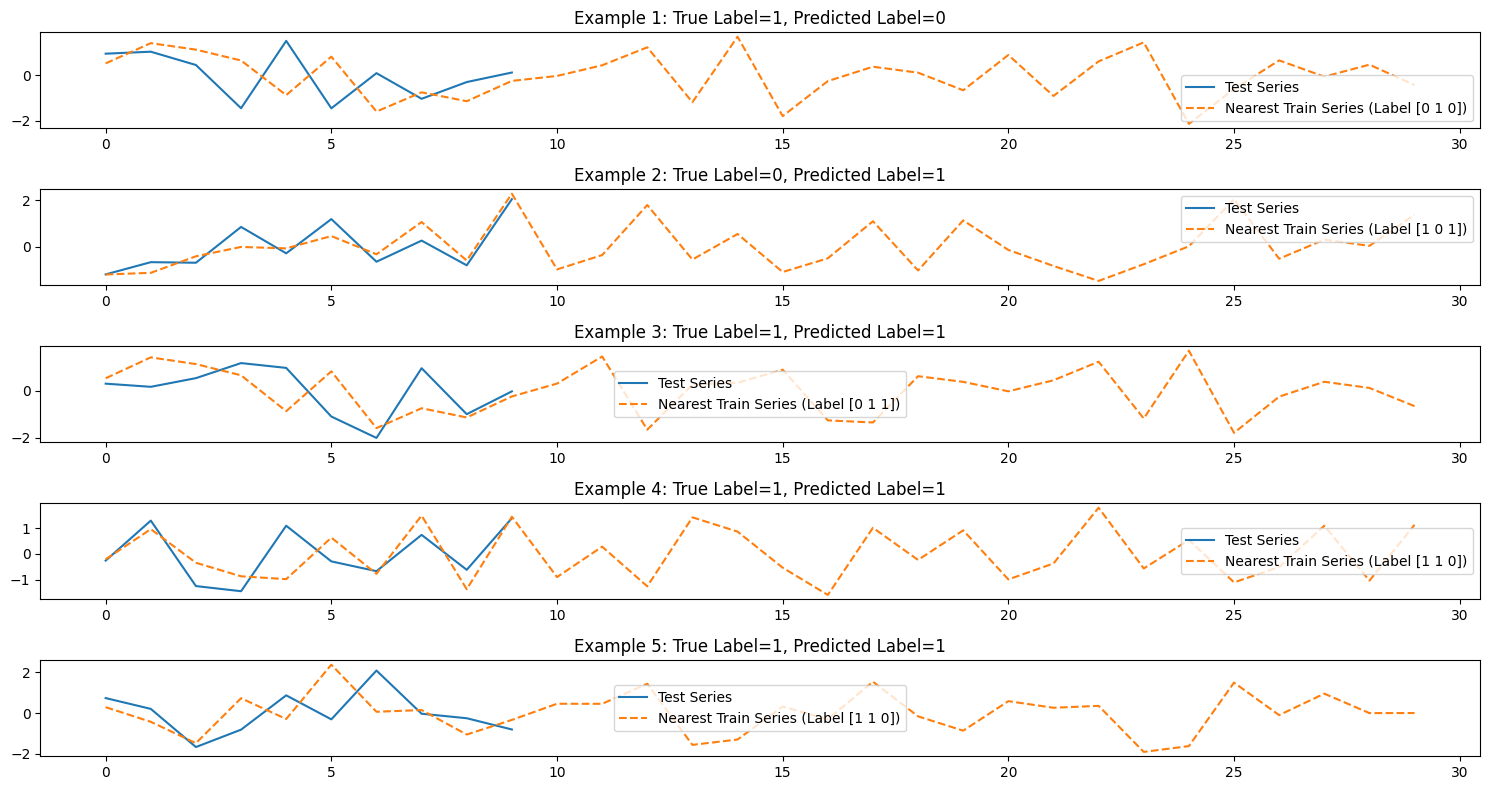

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Assume X_train_scaled e X_test_scaled sono già definiti e in un formato compatibile con tslearn
# Esempio di definizione
np.random.seed(42)
X_train_scaled = np.random.randn(100, 10, 1)
X_test_scaled = np.random.randn(50, 10, 1)
y_train = np.random.randint(0, 2, 100)
y_test = np.random.randint(0, 2, 50)

# Scalare le serie temporali
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# Creare un classificatore k-NN per serie temporali
knn = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")

# Addestramento del modello
knn.fit(X_train_scaled, y_train)

# Predizione
y_pred = knn.predict(X_test_scaled)

# Visualizzazione di Serie Temporali di Esempio con Predizioni
num_examples = 5
example_indices = np.random.choice(len(X_test_scaled), num_examples, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(example_indices):
    series = X_test_scaled[idx].reshape(-1)
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    # Calcola la distanza tra la serie temporale attuale e il vicino più vicino nel training set
    nearest_idx = knn.kneighbors(np.array([X_test_scaled[idx]]), return_distance=False)[0]
    nearest_series = X_train_scaled[nearest_idx].reshape(-1)

    plt.subplot(num_examples, 1, i + 1)
    plt.plot(series, label='Test Series')
    plt.plot(nearest_series, label=f'Nearest Train Series (Label {y_train[nearest_idx]})', linestyle='--')
    plt.title(f'Example {i+1}: True Label={true_label}, Predicted Label={pred_label}')
    plt.legend()

plt.tight_layout()
plt.show()


In [16]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Assume X_train_scaled e X_test_scaled sono già definiti e in un formato compatibile con tslearn
# Esempio di definizione
X_train_scaled = np.random.randn(100, 10, 1)
X_test_scaled = np.random.randn(50, 10, 1)
y_train = np.random.randint(0, 2, 100)
y_test = np.random.randint(0, 2, 50)

# Scalare le serie temporali
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# Creare un classificatore k-NN per serie temporali
knn = KNeighborsTimeSeriesClassifier(n_neighbors=25, metric="dtw")

# Addestramento del modello
knn.fit(X_train_scaled, y_train)

# Predizione
y_pred = knn.predict(X_test_scaled)

# Calcolare l'accuracy del modello
accuracy = knn.score(X_test_scaled, y_test)
print(f'Accuracy: {accuracy}')

# Stampa del report di classificazione
from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.67      0.56        24
           1       0.53      0.35      0.42        26

    accuracy                           0.50        50
   macro avg       0.51      0.51      0.49        50
weighted avg       0.51      0.50      0.49        50



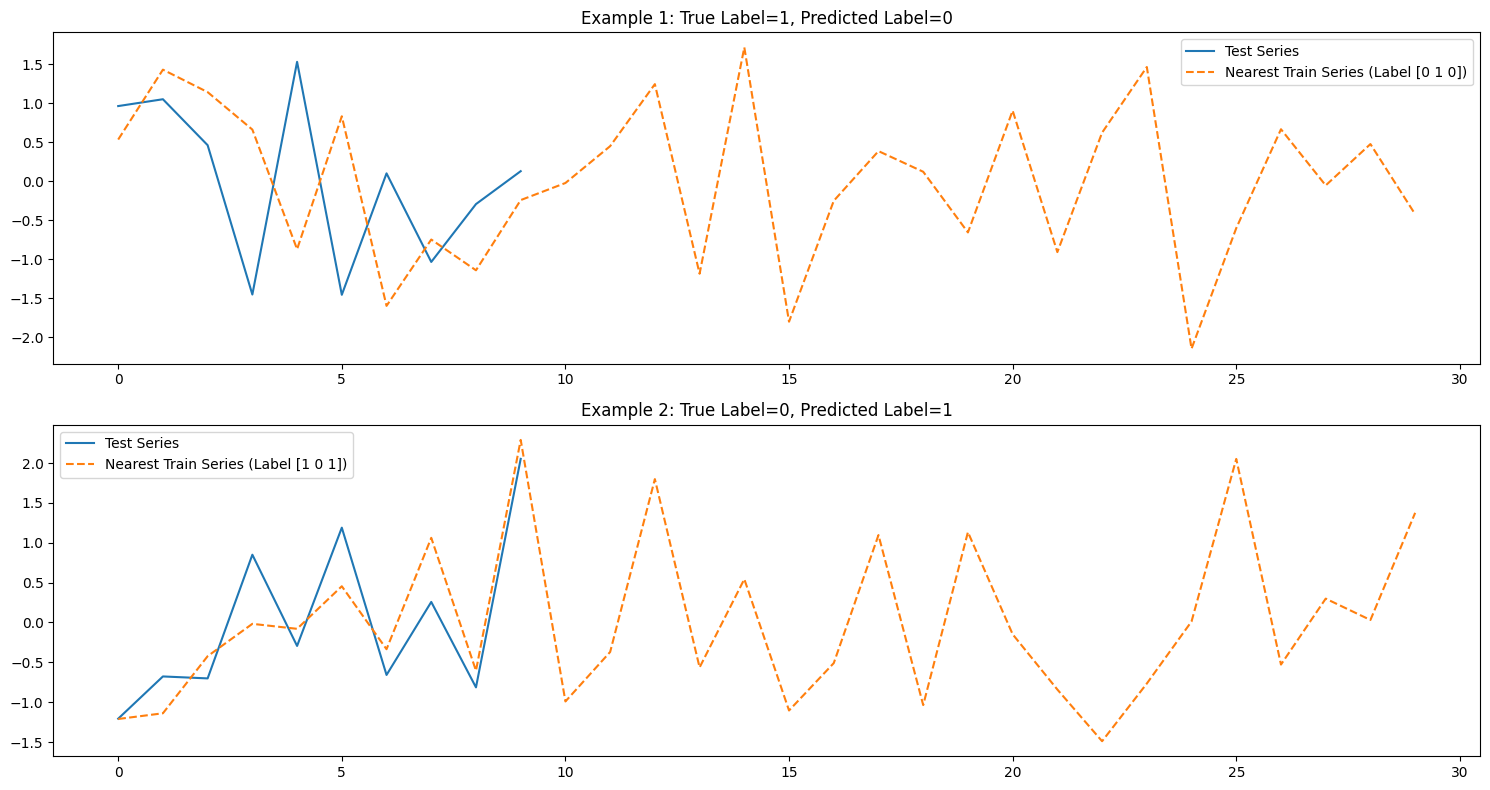

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Assume X_train_scaled e X_test_scaled sono già definiti e in un formato compatibile con tslearn
# Esempio di definizione
np.random.seed(42)
X_train_scaled = np.random.randn(100, 10, 1)
X_test_scaled = np.random.randn(50, 10, 1)
y_train = np.random.randint(0, 2, 100)
y_test = np.random.randint(0, 2, 50)

# Scalare le serie temporali
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# Creare un classificatore k-NN per serie temporali
knn = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")

# Addestramento del modello
knn.fit(X_train_scaled, y_train)

# Predizione
y_pred = knn.predict(X_test_scaled)

# Visualizzazione di Serie Temporali di Esempio con Predizioni
num_examples = 2
example_indices = np.random.choice(len(X_test_scaled), num_examples, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(example_indices):
    series = X_test_scaled[idx].reshape(-1)
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    # Calcola la distanza tra la serie temporale attuale e il vicino più vicino nel training set
    nearest_idx = knn.kneighbors(np.array([X_test_scaled[idx]]), return_distance=False)[0]
    nearest_series = X_train_scaled[nearest_idx].reshape(-1)

    plt.subplot(num_examples, 1, i + 1)
    plt.plot(series, label='Test Series')
    plt.plot(nearest_series, label=f'Nearest Train Series (Label {y_train[nearest_idx]})', linestyle='--')
    plt.title(f'Example {i+1}: True Label={true_label}, Predicted Label={pred_label}')
    plt.legend()

plt.tight_layout()
plt.show()


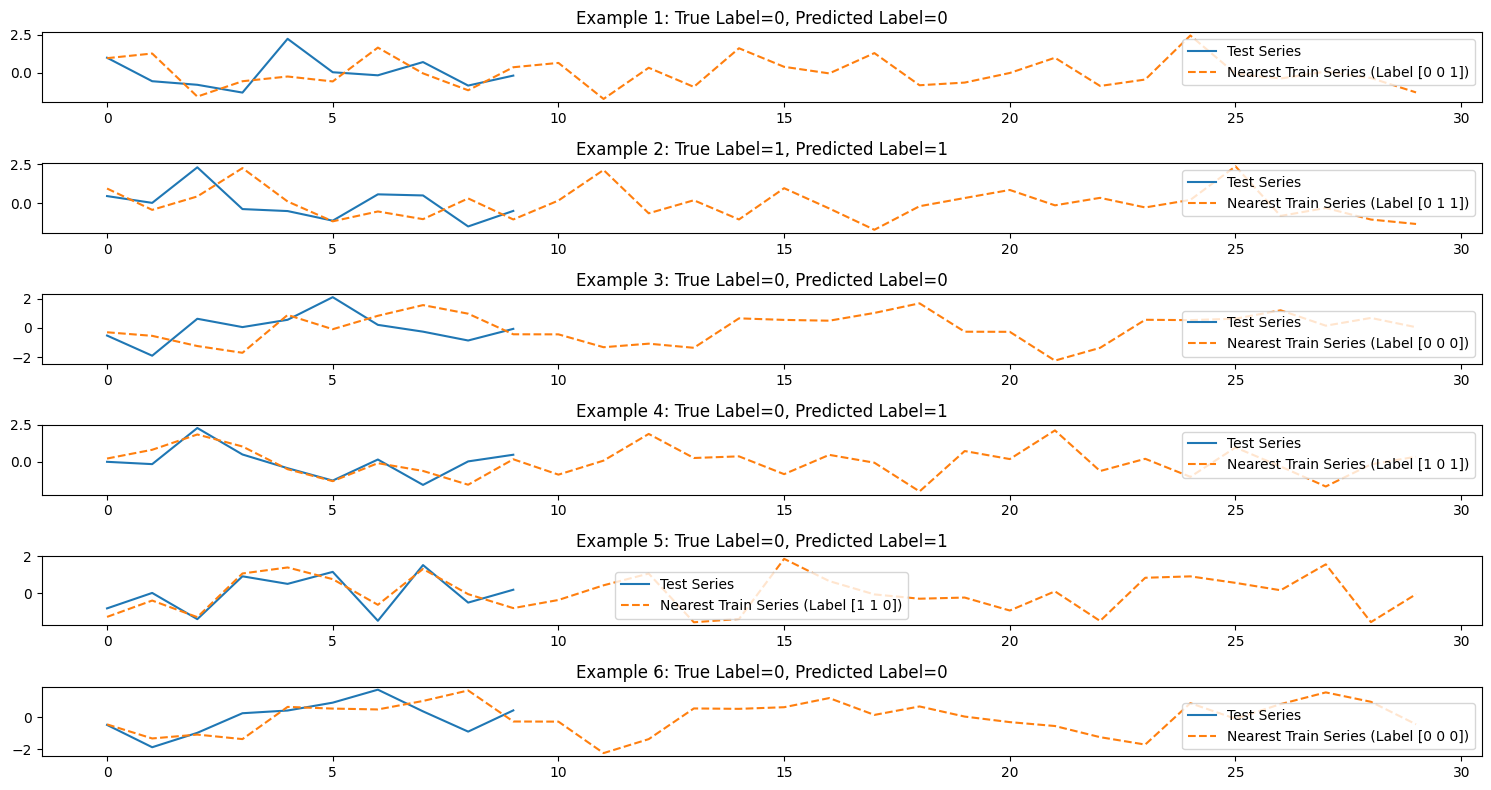

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Assicurati di avere X_train_scaled, X_test_scaled, y_train, y_test definiti e scalati
# Esempio di definizione
X_train_scaled = np.random.randn(100, 10, 1)
X_test_scaled = np.random.randn(50, 10, 1)
y_train = np.random.randint(0, 2, 100)
y_test = np.random.randint(0, 2, 50)

# Scalare le serie temporali
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# Creare un classificatore k-NN per serie temporali
knn = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")

# Addestramento del modello
knn.fit(X_train_scaled, y_train)

# Predizione
y_pred = knn.predict(X_test_scaled)

# Visualizzazione di Serie Temporali di Esempio con Predizioni
num_examples = 6
example_indices = np.random.choice(len(X_test_scaled), num_examples, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(example_indices):
    series = X_test_scaled[idx].reshape(-1)
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    # Calcola la distanza tra la serie temporale attuale e il vicino più vicino nel training set
    nearest_idx = knn.kneighbors(np.array([X_test_scaled[idx]]), return_distance=False)[0]
    nearest_series = X_train_scaled[nearest_idx].reshape(-1)

    plt.subplot(num_examples, 1, i + 1)
    plt.plot(series, label='Test Series')
    plt.plot(nearest_series, label=f'Nearest Train Series (Label {y_train[nearest_idx]})', linestyle='--')
    plt.title(f'Example {i+1}: True Label={true_label}, Predicted Label={pred_label}')
    plt.legend()

plt.tight_layout()
plt.show()

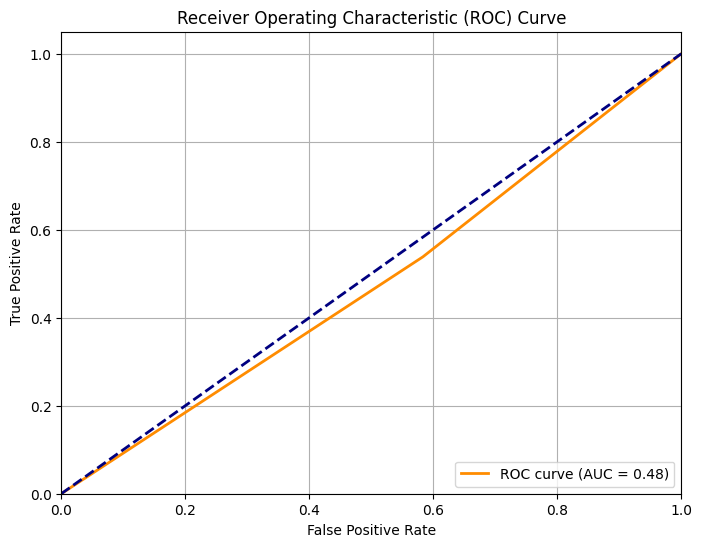

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Calcola il punteggio ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)

# Calcola la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calcola l'area sotto la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Visualizza la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
